In [1]:
### loading dataset
%matplotlib widget

from essential_func import *
### load bkg data data
import sys, os
sys.path.insert(1, os.path.join(os.getcwd(), 'ML', 'dataloader'))
from lesions import *
from scipy import stats 

# specs
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])
lidx =  qgrid_to_indices(qgrid2, 0.4)
uidx =  qgrid_to_indices(qgrid2, 2.0)
column_names= {"bkg":1.}    # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
Excel_File  = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"   # "/home/bashit.a/Codes/ML/Mar-2023-Samples.xlsx"   "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples.xlsx"    sheet       = 'Mar-2023-Samples'
BNL_dir     = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir     = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
val_files   = None # ["1898_CING-roi0_0_0_masked_intp.h5", "1948_EC-roi1_0_0_masked.h5","1948 V1-roi0_0_0_masked.h5","1948_PHG-roi1_0_0_masked.h5"] # None ["1948_HIPPO-roi1_0_0_masked_intp.h5", "2428-roi1_0_0_masked_intp.h5"]
sheet       = 'Mar-2023-Samples'
mica_sub    = False
scaling     = False
tissue_sub  = False

# loading dataset_bkg for visualizing and later on will be split into train, validation, and test set
column_names     = {"bkg":1.}
batch_size       = 1024
split_dataset    = train_val_split_dataset(get_dataframe_with_files_loc)
df_train, _      = split_dataset(Excel_File, sheet, BNL_dir, sub_dir, val_files)
dataset_bkg      = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)

# loading dataset_tissue for testing
column_names       = {"Tissue":0.}
batch_size         = 1
split_dataset      = train_val_split_dataset(get_dataframe_with_files_loc)
df_train, _        = split_dataset(Excel_File, sheet, BNL_dir, sub_dir, val_files)
dataset_tissue     = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)
dataloader_tissue  = DataLoader(dataset_tissue, batch_size=batch_size, num_workers=0)

bkg : contains 94 samples
Tissue : contains 358 samples


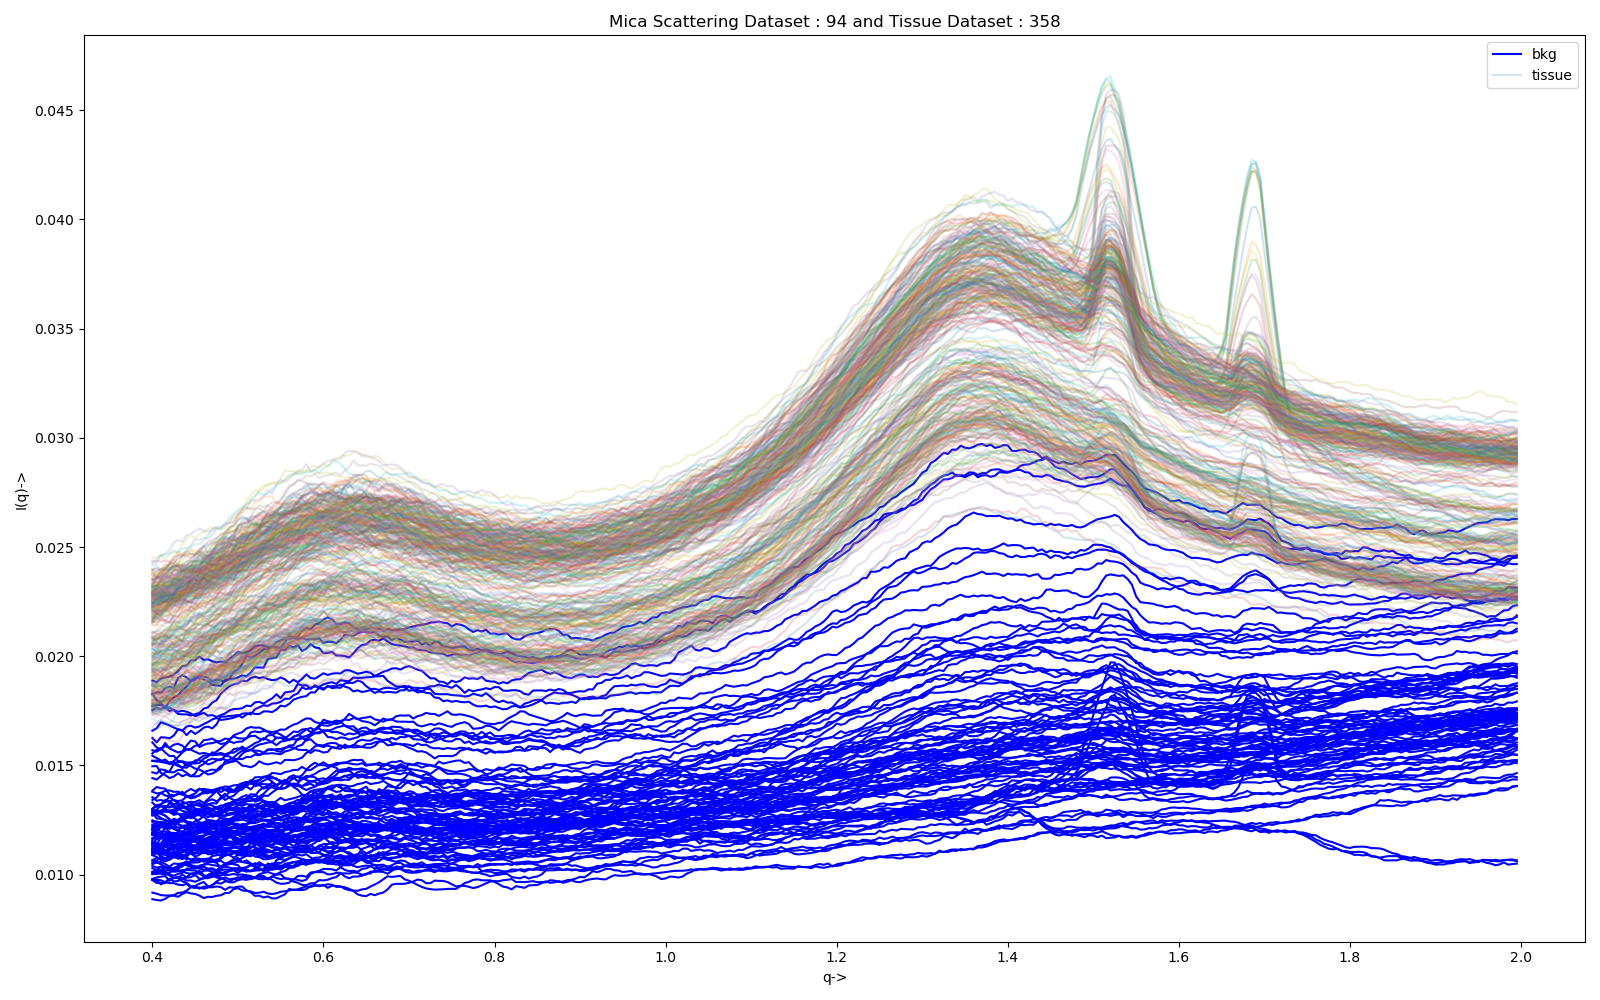

In [2]:
### visualize bkg dataset
plt.close('all')
plt.figure(figsize=(16,10))
bkg_plot   = plt.plot(qgrid2[lidx:uidx], dataset_bkg.x.T, color='blue')
tissue_plt = plt.plot(qgrid2[lidx:uidx], dataset_tissue.x.T, alpha=0.2)
plt.xlabel('q->')
plt.ylabel('I(q)->')
plt.title(f'Mica Scattering Dataset : {len(dataset_bkg.x)} and Tissue Dataset : {len(dataset_tissue.x)}')
plt.tight_layout()
plt.legend([bkg_plot[0], tissue_plt[0]],['bkg','tissue'])
plt.show()

In [3]:
# split - dataset_bkg for training, validation and testing Also 
from torchsummary import summary

split_dataset = {'train': 0.6, 'val':0.2, 'test': 0.2}
batch_size = {'train_batch': 1024, 'val_batch': 1024, 'test_batch': 1}
shuffle_dataset = True
random_seed = 42

np.random.seed(random_seed)
assert sum(list(split_dataset.values())) == 1.0 , 'check if split dataset sums to 1.0'

# Creating data indices for training and validation splits:
indices = np.arange(0,len(dataset_bkg))
if shuffle_dataset :
    np.random.shuffle(indices)

split   = int(split_dataset['train']*len(dataset_bkg))
train_indices, test_indices = indices[:split], indices[split:]
print(f'train size : {len(train_indices)}, test size w/o val : {len(test_indices)}, Total {len(train_indices)+len(test_indices)}')
train_sampler = SubsetRandomSampler(train_indices)
training_loader   = DataLoader(dataset_bkg, batch_size=batch_size['train_batch'], sampler=train_sampler, num_workers=0)

### work on test_indices if validatoin available
validation_loader = 0
if split_dataset.get('val',0):
    new_split_ratio = split_dataset['val']/(split_dataset['val']+ split_dataset['test'])
    split           = int(new_split_ratio*len(test_indices))    
    val_indices, test_indices = test_indices[:split], test_indices[split:]
    print(f'train size: {len(train_indices)}, val size: {len(val_indices)}, test size: {len(test_indices)}, Total {len(train_indices)+len(val_indices)+len(test_indices)}')
    
    valid_sampler = SubsetRandomSampler(val_indices)
    validation_loader = DataLoader(dataset_bkg, batch_size=batch_size['val_batch'], sampler=valid_sampler, num_workers=0)

test_sampler  = SubsetRandomSampler(test_indices)
test_loader   = DataLoader(dataset_bkg, batch_size=batch_size['test_batch'], sampler=test_sampler, num_workers=0)

if validation_loader:
    print("training_loader size : {} ; validation_loader size : {}, test_loader size : {}".format(len(training_loader), len(validation_loader), len(test_loader)))
else:
    print("training_loader size : {} ; test_loader size : {}".format(len(training_loader), len(test_loader)))
### test indices
# train_indices, val_indices, test_indices

train size : 56, test size w/o val : 38, Total 94
train size: 56, val size: 19, test size: 19, Total 94
training_loader size : 1 ; validation_loader size : 1, test_loader size : 19


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 320]              --
|    └─Conv1d: 2-1                       [-1, 1, 320]              1
|    └─LeakyReLU: 2-2                    [-1, 1, 320]              --
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
model saved to : /Users/bashit.a/Documents/Alzheimer/Codes/ML/models/saved-models/micaAE.model


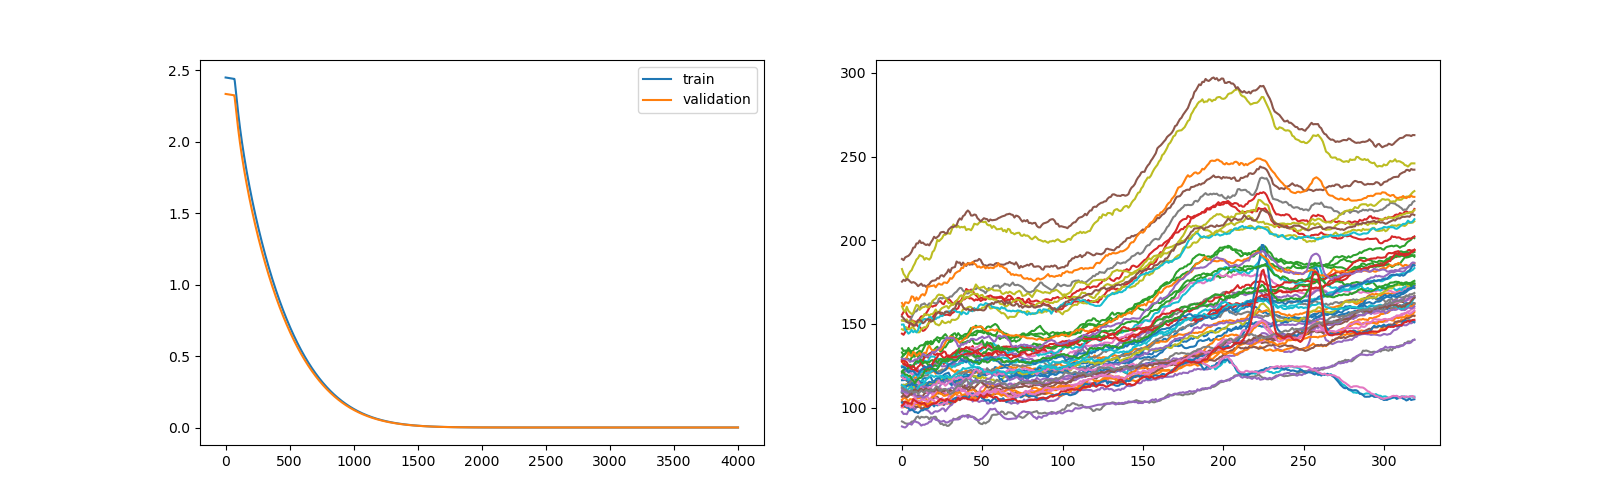

DescribeResult(nobs=4000, minmax=(2.0010606019416066e-11, 2.450819492340088), mean=0.24220606072459872, variance=0.29312544025230947, skewness=2.6657857845244544, kurtosis=6.489815489158238)
DescribeResult(nobs=4000, minmax=(1.9086296779158296e-11, 2.335639715194702), mean=0.23025313671955772, variance=0.2651580954850855, skewness=2.6686124973473646, kurtosis=6.510623191245626)


In [4]:
### Train a model

### import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pylab as plt
from torchsummary import summary

### specs
destination = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/models/saved-models/micaAE.model"
epochs = 4000
learning_rate = 0.001
input_scale = 100
torch.manual_seed(12)

### model architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.LeakyReLU(negative_slope=0.03),
        )
    
    def forward(self, x):
        x = self.linear(x)
        return x

### model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder()
model.to(device)
summary(model, (1,320))
criterion  = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=learning_rate)


### create loss array
train_loss = np.array([])
val_loss   = np.array([])

if validation_loader:
    val_in = next(iter(validation_loader))[0]
    val_in = input_scale*val_in.unsqueeze(1).to(device)

epoch  = 1 
while epoch <= epochs:
    model.train()
    ### run on training dataset
    for bx, (input, label) in enumerate(training_loader):
        input = input_scale*input.unsqueeze(1).to(device)
        model.train()
        target = model(input)
        loss = criterion(input, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = np.hstack((train_loss,loss.item()))
    
    ### run on testing dataset
    if validation_loader:
        model.eval()
        with torch.no_grad():
            ypred  = model(val_in)
            val_loss_fn  = criterion(val_in, ypred)
            val_loss = np.hstack((val_loss, val_loss_fn.item()))
    epoch += 1

### saving model
print(f'model saved to : {destination}')
torch.save(model.state_dict(), destination)

### plot training results
plt.close('all')
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='validation')
axs[0].legend()
axs[1].plot(input_scale*target.squeeze(1).detach().numpy().T)
plt.show()
print(stats.describe( train_loss))
if validation_loader:
    print(stats.describe( val_loss))

---------------------------train---------------------------
chosen thresold based on train loss at percentile of 97: 4.014229487009359e-11
train stats : --->  DescribeResult(nobs=56, minmax=(9.936973119351045e-12, 4.944809145479567e-11), mean=1.9978408452011163e-11, variance=7.28804433106059e-23, skewness=1.5269266366124312, kurtosis=2.265269071233364)
---------------------------val---------------------------
threshold is : 4.014229487009359e-11
Accuracy : 100.0%
val stats : --->  DescribeResult(nobs=19, minmax=(1.105314711286054e-11, 3.703899340012917e-11), mean=1.903577231881182e-11, variance=4.109591804298541e-23, skewness=1.2179972624422393, kurtosis=1.5321263262922953)
---------------------------test---------------------------
threshold is : 4.014229487009359e-11
Accuracy : 89.47%
test stats : --->  DescribeResult(nobs=19, minmax=(1.3914869256836937e-11, 4.5103965701231985e-11), mean=2.0464710792206535e-11, variance=7.134800884408344e-23, skewness=2.108174988871883, kurtosis=3.291

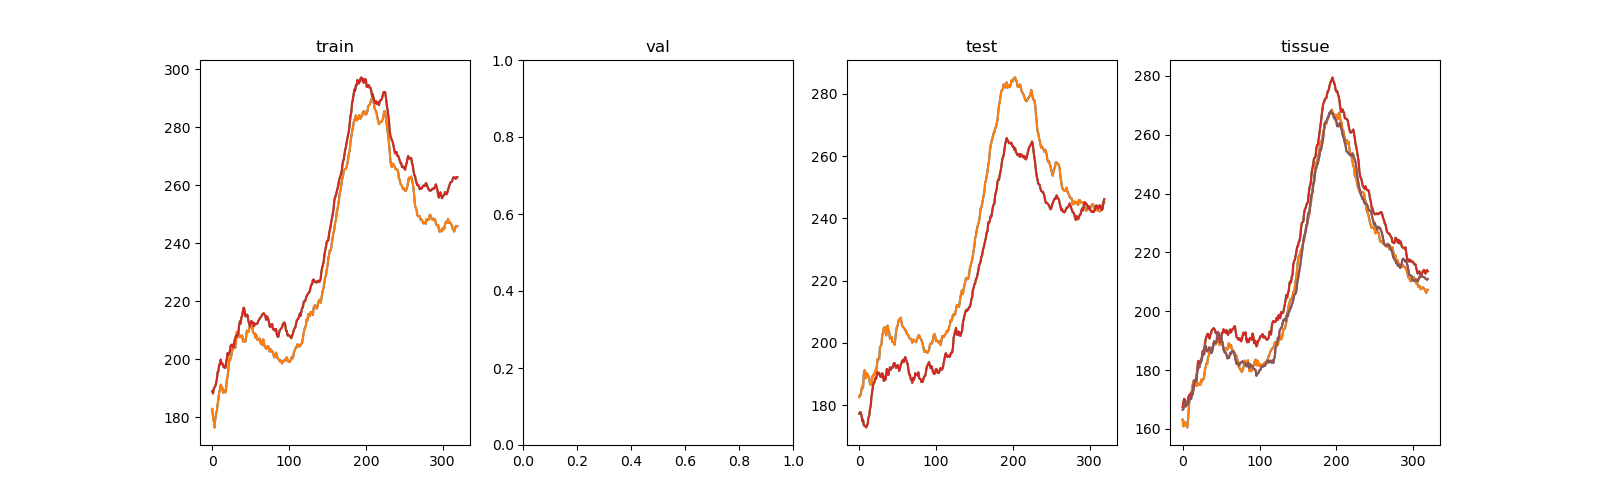

In [20]:
### Choosing threshold from training dataset
%matplotlib widget
indices_list = [(0,'train', dataset_bkg, training_loader.sampler.indices, 'regular'), (1, 'val', dataset_bkg, validation_loader.sampler.indices, 'regular'), (2, 'test', dataset_bkg, test_loader.sampler.indices, 'regular'), (3, 'tissue', dataset_tissue, np.arange(0,len(dataset_tissue)), 'anomaly')]
percentile = 97
thr = ('train', percentile)  # 0.03028420664  ('val', percentile) 
thr_in = thr

def get_loss(model, criterion, label, dataset, indices, input_scale, mode, thr, show_plot=False, print_results = False, ax=None):
    model.eval()
    loss_results = {}
    if isinstance(thr, tuple) and label!=thr[0]:
        return (None, None)
        
    with torch.no_grad():
        if show_plot:
            if not ax:
                f,ax = plt.subplots()
            ax.set_title(label)        
        counts = 0
        test_loss = np.array([])
        print(f'---------------------------{label}---------------------------')
        for idx in indices:            
            test, file, frame  = dataset.x[idx], dataset.files[idx], dataset.frames[idx]
            test  = input_scale*torch.tensor(test, dtype=torch.float32)
            test.unsqueeze_(0).unsqueeze_(0)
            ypred = model(test)
            loss  = criterion(test, ypred)
            test_loss = np.hstack((test_loss, loss.item()))
            
            if isinstance(thr, float) and (loss.item() > thr if mode=='regular' else loss.item() < thr):
                if print_results:
                    print(f'{thr, loss.item(), file, frame}')
                if show_plot:
                    ax.plot(input_scale*ypred.squeeze(1).detach().numpy().T,)
                    ax.plot(input_scale*test.squeeze(1).detach().numpy().T, label = file  + str(frame))
                    
                counts += 1
        
        if isinstance(thr, float):
            accuracy = (len(test_loss)-counts)/len(test_loss)*100
            print(f'threshold is : {thr}')
            print(f'Accuracy : {accuracy:0.4}%')
        else:
            thr = np.percentile(test_loss, percentile)
            print(f'chosen thresold based on {label} loss at percentile of {percentile}: {thr}')
        print(f'{label} stats : ---> ', stats.describe( test_loss))
    return thr, test_loss

plt.close('all')
f, axs = plt.subplots(ncols=len(indices_list), nrows=1, figsize=(16,5))
loss = {}
for indices in indices_list:
    if not isinstance(thr, float):
        indices_list.append(indices)
    
    i, label, dataset, idxs, mode = indices
    thr, loss[label] = get_loss(model, criterion, label, dataset, idxs, input_scale, mode, thr, show_plot=True, print_results = False, ax=axs[i])

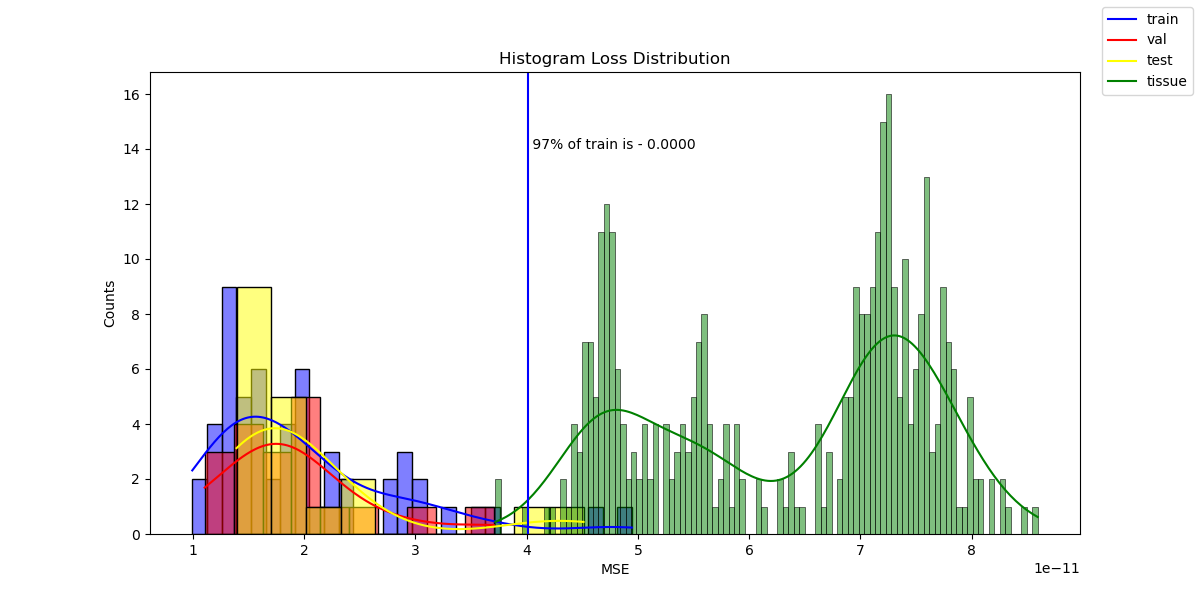

In [21]:
import seaborn as sns
plt.close('all')

lower_threshold = loss['train'].min()
upper_threshold = thr
f = plt.figure(figsize=(12,6))
plt.title('Histogram Loss Distribution')
sns.histplot(loss['train'],bins=30,kde=True, color='blue')
sns.histplot(loss['val'],bins=10,kde=True, color='red')
sns.histplot(loss['test'],bins=10,kde=True, color='yellow')
sns.histplot(loss['tissue'],bins=100,kde=True, color='green')
f.legend(['train','val','test','tissue'])
plt.axvline(upper_threshold, 0.0, 10, color='blue')
plt.xlabel("MSE")
plt.ylabel("Counts")
plt.annotate(f' {percentile}% of {thr_in[0]} is - {thr:0.4f}', (thr,14))
plt.show()

42 41
Frames : contains 1722 samples
62 122
Frames : contains 7564 samples
---------------------------1898_CING-roi1_0_0_masked.h5---------------------------
threshold is : 4.014229487009359e-11
Accuracy : 97.62%
1898_CING-roi1_0_0_masked.h5 stats : --->  DescribeResult(nobs=1722, minmax=(2.302611400162302e-11, 1.1053522680493089e-10), mean=4.752203215101555e-11, variance=2.0707962500830786e-23, skewness=2.82715860500287, kurtosis=42.3520162914805)
162,163,275,304,641,642,654,655,688,689,690,737,738,739,765,766,772,773,792,829,830,831,832,837,838,871,881,1066,1118,1184,1185,1249,1250,1251,1257,1258,1260,1261,1262,1269,1270
(array([0., 1.]), array([1681,   41]))
---------------------------1948_PHG-roi0_0_0_masked.h5---------------------------
threshold is : 4.014229487009359e-11
Accuracy : 99.09%
1948_PHG-roi0_0_0_masked.h5 stats : --->  DescribeResult(nobs=7564, minmax=(2.7003644112455483e-11, 2.7689281423270984e-10), mean=7.713670937569255e-11, variance=2.593276425848021e-22, skewness

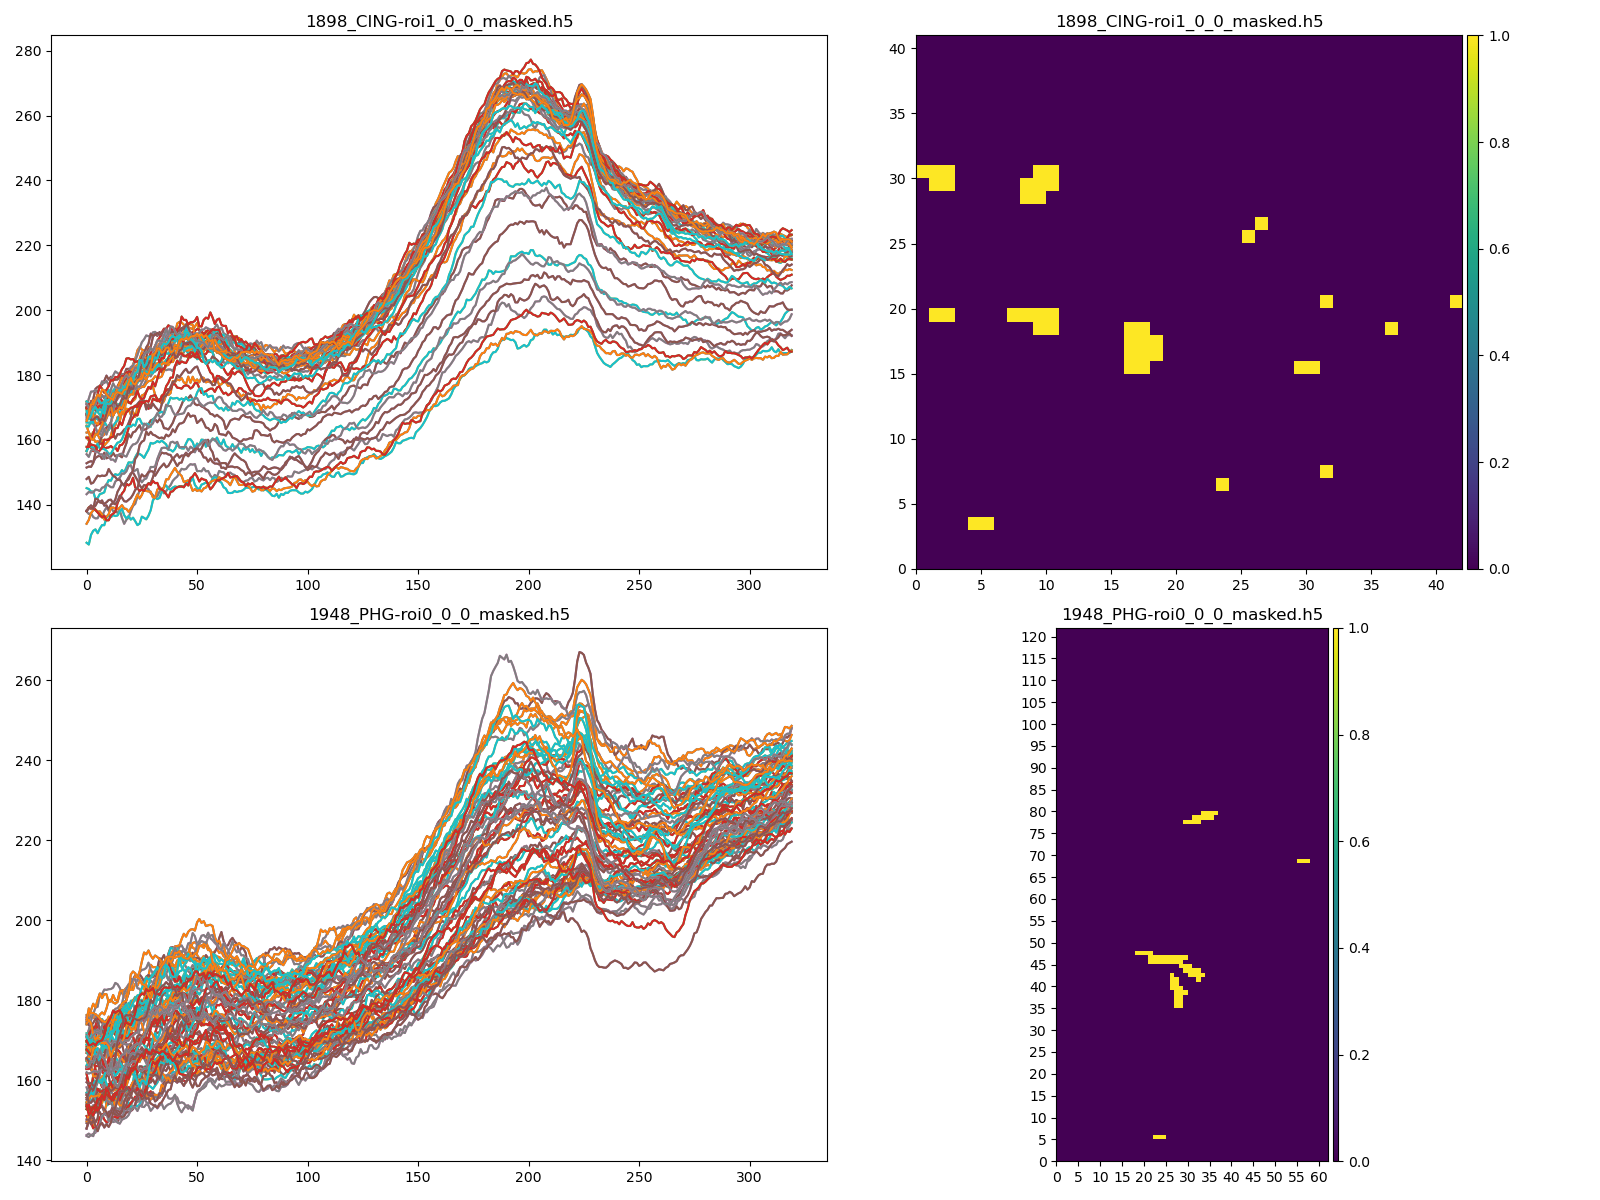

In [22]:
### plot ROI
%matplotlib widget
import sys
sys.setrecursionlimit(10000)

# load mica model
model = AutoEncoder()
model.to(device)
model.load_state_dict(torch.load(destination))

### parameters
column_names      = {"Frames":1.0}   ### Dummy column
BNL_dir           = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir           = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV

### modify here -----------------------------------
input_files         = ["1898_CING-roi1_0_0_masked.h5" , "1948_PHG-roi0_0_0_masked.h5"] # "2068_PHG_2-roi0_0_0_masked_intp.h5"  (42,42) # "1898_CING-roi0_0_0_masked_intp.h5" (41,41) # "1948_EC-roi1_0_0_masked.h5" # "1898_CING-roi0_0_0_masked_intp.h5"  # "1948 V1-roi0_0_0_masked.h5"

input_file_locs     = [f'/Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/{input_files[0]}_merged.csv', f'/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/{input_files[1]}_merged.csv'] # '/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948 V1-roi0_0_0_masked.h5_merged.csv'
inputs_width_height = [(42,41), (62, 122) ]  # (62,61)
### -----------------------------------

indices_list = []
for idx in range(len(input_files)):
    df = pd.DataFrame({"File": [None], "File_Loc": [None], "Frames": [None]}, dtype=str)

    df.at[idx, "File"]     = input_files[idx]
    df.at[idx, "File_Loc"] = input_file_locs[idx]
    Width, Height          = inputs_width_height[idx]
    print(Width, Height)
    df.at[idx, "Frames"]   = str(np.arange(0, Width*Height,dtype=int).tolist())    
    dataset = XrayData(df, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)
    
    indices_list.append(( input_files[idx], (Width, Height), dataset, eval(df.at[idx, "Frames"]), 'anomaly'))

# indices_list = [(4, input_file, dataset, eval(df.Frames[0]), 'anomaly') , ]
plt.close('all')
f, axs = plt.subplots(ncols=2, nrows=len(indices_list), figsize=(16,12))

for idx, indices in enumerate(indices_list):
    label, width_height, dataset, idxs, mode = indices
    Width, Height = width_height
    thr, loss[label] = get_loss(model, criterion, label, dataset, idxs, input_scale, mode, thr, show_plot=True, print_results = False, ax=axs[idx,0])

    diff_patterns = np.zeros((Width*Height))
    arr_fr = np.arange(0, Width*Height,dtype=int)
    sel_fr = np.where(loss[label] < thr)[0]
    print(*sel_fr, sep=',')
    diff_patterns[ arr_fr[ sel_fr]] = 1
    print(np.unique(diff_patterns, return_counts=True))

    img_orig    = snaking(Width, Height, diff_patterns)
    plot_heat_map_from_data(img_orig, Width, Height, args=(f,axs[idx,1]), title= label, cmap="viridis", norm=None, ticks=None, alpha=None)
plt.tight_layout()

In [13]:
len(input_files)

3

In [210]:
### get counts of each ROI for dataset_bkg
dataset_summary = pd.DataFrame({"Files": dataset_bkg.files[training_loader.sampler.indices], "bkg_frame": dataset_bkg.frames[training_loader.sampler.indices]})  # training_loader test_loader validation_loader train
dataset_summary.to_clipboard()

with pd.option_context('display.max_colwidth', None):
    df = dataset_summary.groupby(["Files"], as_index=False).size()
    display(df)
    df.to_clipboard()
print(f'Total Samples : {df["size"].sum()}')

Files  \
0           /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_CING-roi0_0_0_masked_intp.h5_merged.csv   
1             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi0_0_0_masked_intp.h5_merged.csv   
2              /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC_bkg-roi0_0_0_masked.h5_merged.csv   
3          /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO-roi2_0_0_masked_intp.h5_merged.csv   
4           /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO_bkg-roi0_0_0_masked.h5_merged.csv   
5                  /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V1-roi0_0_0_masked.h5_merged.csv   
6             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V2-roi0_0_0_masked_intp.h5_merged.csv   
7             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V2-roi1_0_0_masked_intp.h5_merged.csv   
8                  /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi0_0_0_masked.h5_merged.csv   
9                  /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi1_0_0_masked.h5_merged.csv   
10                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi2_0_0_masked.h5_merged.csv   
11         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi1_0_0_masked_intp.h5_merged.csv   
12                /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi0_0_0_masked.h5_merged.csv   
13                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_V2-roi0_0_0_masked.h5_merged.csv   
14                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_V2-roi1_0_0_masked.h5_merged.csv   
15          /Volumes/HDD/BNL-Data/Mar-2023/1968/CSV_Conv-8-point/1968_Hippo_CA3-roi0_0_0_masked.h5_merged.csv   
16                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi0_0_0_masked.h5_merged.csv   
17                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi1_0_0_masked.h5_merged.csv   
18         /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv   
19         /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv   
20                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_V1-roi1_0_0_masked.h5_merged.csv   
21               /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_CING-roi1_0_0_masked.h5_merged.csv   
22           /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_PHG-roi0_0_0_masked_intp.h5_merged.csv   
23         /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_PHG_2-roi0_0_0_masked_intp.h5_merged.csv   
24                 /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V1-roi0_0_0_masked.h5_merged.csv   
25            /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V2-roi0_0_0_masked_intp.h5_merged.csv   
26                 /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V2-roi1_0_0_masked.h5_merged.csv   
27               /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_CING-roi0_0_0_masked.h5_merged.csv   
28              /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_Hippo-roi0_0_0_masked.h5_merged.csv   
29             /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_V2_bkg-roi0_0_0_masked.h5_merged.csv   
30  /Volumes/HDD/BNL-Data/Mar-2023/Misc/CSV_Conv-8-point/2048_B8_UNSTAINED-roi0_0_0_masked_intp.h5_merged.csv   

    size  
0      1  
1      2  
2      1  
3      3  
4      2  
5      3  
6      1  
7      3  
8      1  
9      2  
10     3  
11     1  
12     2  
13     3  
14     2  
15     2  
16     2  
17     2  
18     1  
19     2  
20     1  
21     1  
22     1  
23     2  
24     2  
25     3  
26     2  
27     2  
28     1  
29     1  
30     1

Total Samples : 56


In [213]:
### get counts of each ROI for dataset_bkg
dataset_summary = pd.DataFrame({"Files": dataset_tissue.files, "bkg_frame": dataset_tissue.frames})  # training_loader test_loader validation_loader train
dataset_summary.to_clipboard()

with pd.option_context('display.max_colwidth', None):
    df = dataset_summary.groupby(["Files"], as_index=False).size()
    display(df)
    df.to_clipboard()
print(f'Total Samples : {df["size"].sum()}')

Files  \
0    /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_CING-roi0_0_0_masked_intp.h5_merged.csv   
1      /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi0_0_0_masked_intp.h5_merged.csv   
2      /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi1_0_0_masked_intp.h5_merged.csv   
3   /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO-roi2_0_0_masked_intp.h5_merged.csv   
4           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948 V1-roi0_0_0_masked.h5_merged.csv   
5           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi0_0_0_masked.h5_merged.csv   
6           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi1_0_0_masked.h5_merged.csv   
7           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi2_0_0_masked.h5_merged.csv   
8        /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi0_0_0_masked.h5_merged.csv   
9   /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi1_0_0_masked_intp.h5_merged.csv   
10         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi0_0_0_masked.h5_merged.csv   
11         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi1_0_0_masked.h5_merged.csv   
12          /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi0_0_0_masked.h5_merged.csv   
13          /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi1_0_0_masked.h5_merged.csv   
14  /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv   
15  /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv   

    size  
0      6  
1      5  
2      6  
3     16  
4     34  
5     18  
6     30  
7      3  
8     65  
9     42  
10    10  
11    17  
12    44  
13    20  
14     5  
15    37

Total Samples : 358
